Cross-Correlation: MAE=4.886, RMSE=4.886, Accuracy=80.54%
Peak Detection: MAE=6.865, RMSE=12.607, Accuracy=72.66%
Phase Correlation: MAE=3.584, RMSE=3.804, Accuracy=85.73%


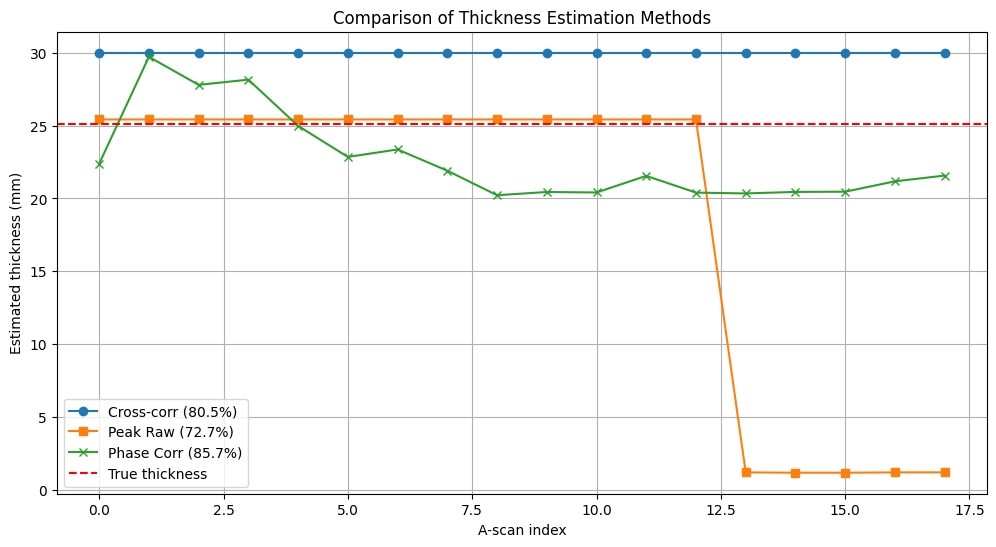

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, butter, filtfilt, find_peaks, correlation_lags
from numpy.fft import fft, ifft
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import files
# ---------------- Upload Data ----------------
uploaded = files.upload()
# ---------------- Parameters ----------------
fs = 125e6         # Sampling frequency (Hz)
dt = 1 / fs
c = 5900.0   # Speed of sound in steel (m/s)
true_thickness = 25.11  # ground truth (mm)

# ----------------Functions ----------------
def bandpass_filter(signal, fs=125e6, lowcut=1e6, highcut=20e6, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def normalize(signal):
    signal = signal - np.mean(signal)
    norm = np.linalg.norm(signal)
    if norm == 0:
        return signal
    return signal / norm

def evaluate(estimated, method_name):
    est = np.array(estimated)
    est = est[~np.isnan(est)]
    mae = mean_absolute_error(np.ones_like(est) * true_thickness, est)
    rmse = np.sqrt(mean_squared_error(np.ones_like(est) * true_thickness, est))
    acc = 100 * (1 - mae / true_thickness)
    print(f"{method_name}: MAE={mae:.3f}, RMSE={rmse:.3f}, Accuracy={acc:.2f}%")
    return mae, rmse, acc

data = np.load("non_saturated_waveform.npz")
ascans = data["a_scans"]

template_file = np.load("template_extracted.npz")
template = template_file["waveform"]

# ---------------- Cross-Correlation ----------------
def cross_correlation(sig, template, dt, c, search_range=None):
    sig = normalize(bandpass_filter(sig))
    template = normalize(bandpass_filter(template))

    # Apply Hann windows
    win_sig = sig * np.hanning(len(sig))
    win_temp = template * np.hanning(len(template))

    corr = correlate(win_sig, win_temp, mode="full")
    lags = correlation_lags(len(win_sig), len(win_temp), mode="full")

    # Restrict search range if defined
    if search_range:
        min_mm, max_mm = search_range
        min_samp = int((min_mm*1e-3*2 / c) / dt)
        max_samp = int((max_mm*1e-3*2 / c) / dt)
        mask = (lags >= min_samp) & (lags <= max_samp)
        corr = corr[mask]
        lags = lags[mask]

    max_idx = np.argmax(corr)
    delay_samples = lags[max_idx]

    delay_time = delay_samples * dt
    return (delay_time * c / 2) * 1000  # mm

estimated_corr = [cross_correlation(ascan, template, dt, c, search_range=(20,30)) for ascan in ascans]

# ---------------- Method 2: Peak detection (raw) ----------------
estimated_peaks_raw = []
for ascan in ascans:
    sig = normalize(bandpass_filter(ascan))
    peaks, _ = find_peaks(np.abs(sig), height=0.1*np.max(sig), distance=50)
    if len(peaks) > 1:
        delay_samples = peaks[1] - peaks[0]
        delay_time = delay_samples * dt
        estimated_peaks_raw.append((delay_time * c / 2) * 1000)
    else:
        estimated_peaks_raw.append(np.nan)

# ---------------- Phase Correlation----------------
def phase_correlation(sig, template, dt, c, search_range=None):
    sig = normalize(bandpass_filter(sig))
    template = normalize(template)

    n = len(sig) + len(template)
    SIG = np.fft.fft(sig, n=n)
    TMP = np.fft.fft(template, n=n)
    R = SIG * np.conj(TMP)
    R /= (np.abs(R) + 1e-12)

    cc = np.fft.ifft(R).real
    cc = cc[:len(sig)]

    if search_range:
        min_mm, max_mm = search_range
        min_samp = int((min_mm*1e-3*2 / c) / dt)
        max_samp = int((max_mm*1e-3*2 / c) / dt)
        mask = np.zeros_like(cc)
        mask[min_samp:max_samp] = 1
        cc = cc * mask

    max_idx = np.argmax(cc)
    delay_samples = max_idx

    if 0 < max_idx < len(cc)-1:
        y0, y1, y2 = cc[max_idx-1], cc[max_idx], cc[max_idx+1]
        denom = (y0 - 2*y1 + y2)
        if denom != 0:
            delta = 0.5 * (y0 - y2) / denom
            delay_samples += delta

    delay_time = delay_samples * dt
    return (delay_time * c / 2) * 1000  # mm

est4 = [phase_correlation(ascan, template, dt, c, search_range=(20,30)) for ascan in ascans]

# ---------------- Evaluate Methods ----------------
mae_corr, rmse_corr, acc_corr = evaluate(estimated_corr, "Cross-Correlation")
mae_raw, rmse_raw, acc_raw = evaluate(estimated_peaks_raw, "Peak Detection")
mae_phc, rmse_phc, acc_phc = evaluate(est4, "Phase Correlation")

# ---------------- Comparison Plot ----------------
plt.figure(figsize=(12,6))
plt.plot(estimated_corr, "o-", label=f"Cross-corr ({acc_corr:.1f}%)")
plt.plot(estimated_peaks_raw, "s-", label=f"Peak Raw ({acc_raw:.1f}%)")
plt.plot(est4, "x-", label=f"Phase Corr ({acc_phc:.1f}%)")
plt.axhline(true_thickness, color="r", linestyle="--", label="True thickness")
plt.xlabel("A-scan index")
plt.ylabel("Estimated thickness (mm)")
plt.title("Comparison of Thickness Estimation Methods")
plt.legend()
plt.grid(True)
plt.show()